# Fruit Inspection
Project for Computer Vision exam, University of Bologna
By Valentina Boriano (valentina.boriano@studio.unibo.it) and Pietro Fanti (pietro.fanti@studio.unibo.it)

## Task 1:  Fruit segmentation and edge detection
### Preliminary operations and images import

In [1]:
# Import libraries

import cv2
from matplotlib import pyplot as plt
import numpy as np
import statistics 

In [2]:
#will show images centered

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
# Set some constants needed in the code

FILENAMES = ["000001","000002","000003"]
N = len(FILENAMES)

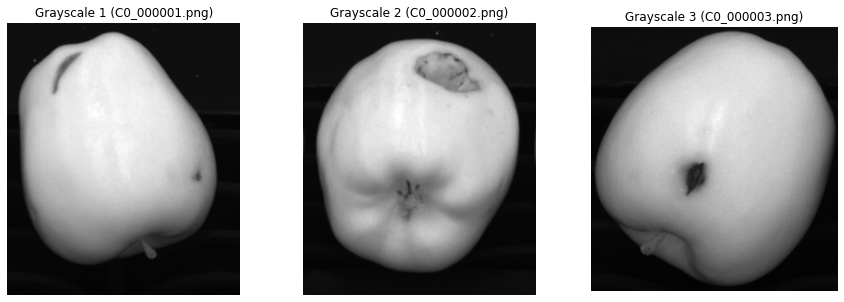

In [4]:
# Import grayscales images acquired through a NIR (Near Infra-Red)
# Then show them

grayscales = []
plt.figure(figsize=(15, 5))

for i, name in enumerate(FILENAMES):
    img = cv2.imread("img/first task/C0_{0}.png".format(name), cv2.IMREAD_GRAYSCALE)
    grayscales.append(img)
    plt.subplot(1,N,i+1).axis("off")
    plt.title("Grayscale {0} (C0_{1}.png)".format(i+1, name))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

### Fruit segmentation

At first, we want to obtain a binary mask of the fruit for each image, then we will put in evidence imperfections through a flood-fill approach.
In order to do this we will plot the pixel value histogram of each image to see if a threshold can be easily determined.

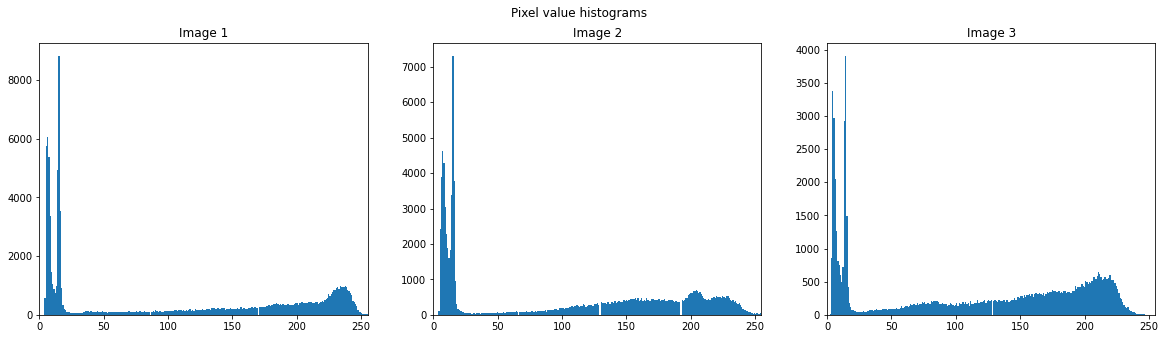

In [5]:
# Plot pixel value histogram of img
def plot_histogram(img, i):
    # flatten to 1D array
    vals = img.flatten()
    # plot histogram with 255 bins
    plt.subplot(1,N,i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])



fig = plt.figure(figsize=(20, 5))
for i, img in enumerate(grayscales):
    plot_histogram(img, i)
fig.suptitle("Pixel value histograms")
plt.show()

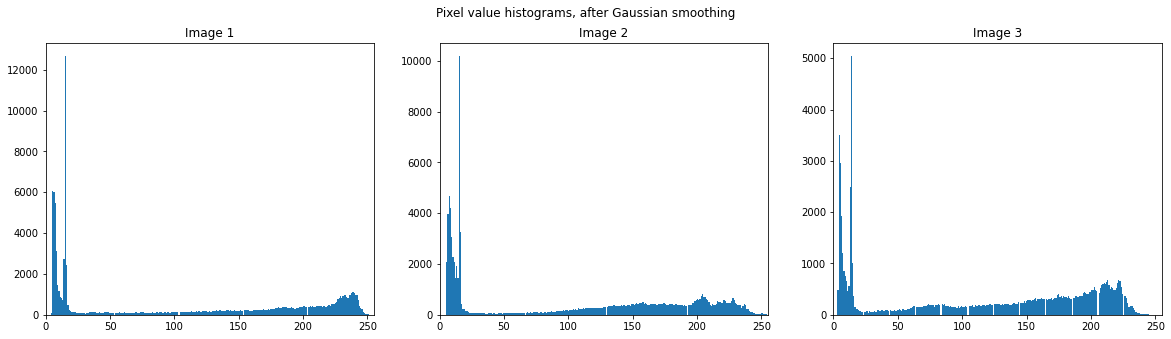

In [6]:
blurred = []
fig = plt.figure(figsize=(20,5))
for i, img in enumerate(grayscales):
    blur = cv2.GaussianBlur(img,(5,5),0)
    blurred.append(blur)
    plot_histogram(blur, i)
fig.suptitle("Pixel value histograms, after Gaussian smoothing")
plt.show()

It is not possible to determine a threshold from the histogram for any of the images, so we need a less naive approach. __Otsu's algorithm__ allow us to obtain the optimal threshold (the one which minimizes the _Within-group Variance_)

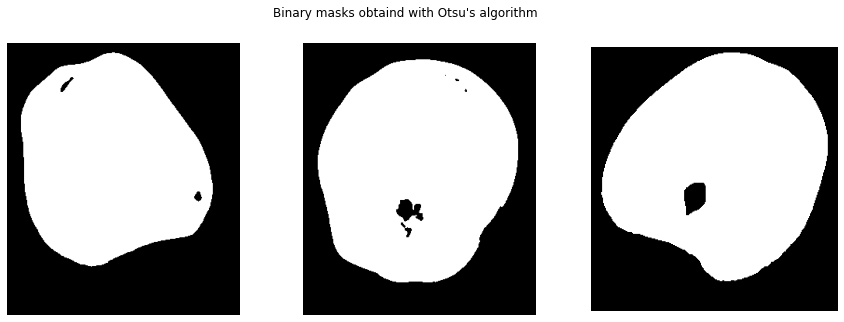

In [7]:
masks = []

fig = plt.figure(figsize=(15,5))
for i, img in enumerate(blurred):
    ret, mask = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    plt.subplot(1,N,i+1).axis("off")
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
fig.suptitle("Binary masks obtaind with Otsu's algorithm")
plt.show()

Now we empirically assume that the left-top corner pixel will always belong to the background, so we can __flood-fill images with seed (0,0)__ to separate the background from the blobs inside fruits

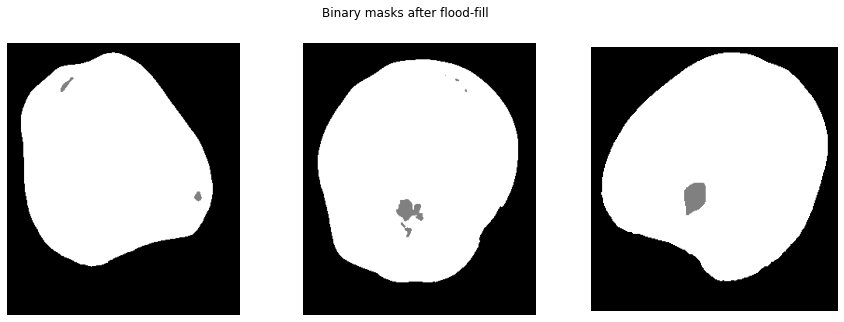

In [8]:
ff_masks = []

fig = plt.figure(figsize=(15,5))
for i, m in enumerate(masks):
    # Add 1 to each pixel, then set the background to 0. Having it set to 0 will simplify further calculus
    ff_m = m + 1
    cv2.floodFill(ff_m, None, (0,0), 0)
    ff_masks.append(ff_m)
    plt.subplot(1,N,i+1).axis("off")
    plt.imshow(ff_m, cmap="gray", vmin=0, vmax=2)
fig.suptitle("Binary masks after flood-fill")
plt.show()

Now each image contains information about where the background, the fruit and the "imperfections" are. However, in the second image the calyx is classified as an imperfection and the real imperfection, which is lighter than the calyx, is barely visible.
We hope to obtain better results with an edge detection approach.

### Edge detection
To do edge detection we have used Canny's algorithm, which take as parameters two thresholds.
We have tried with different couple of values (and we have tried to use Gaussian blurred images as well) without find out a perfect and fixed couple which gives perfect results for all the images: with low values the calyx in the second image is detected as-well (__false positive__), on the other hand, with higher values, the calyx disappears, but in the first image the smaller imperfection disappears too (__false negative__).

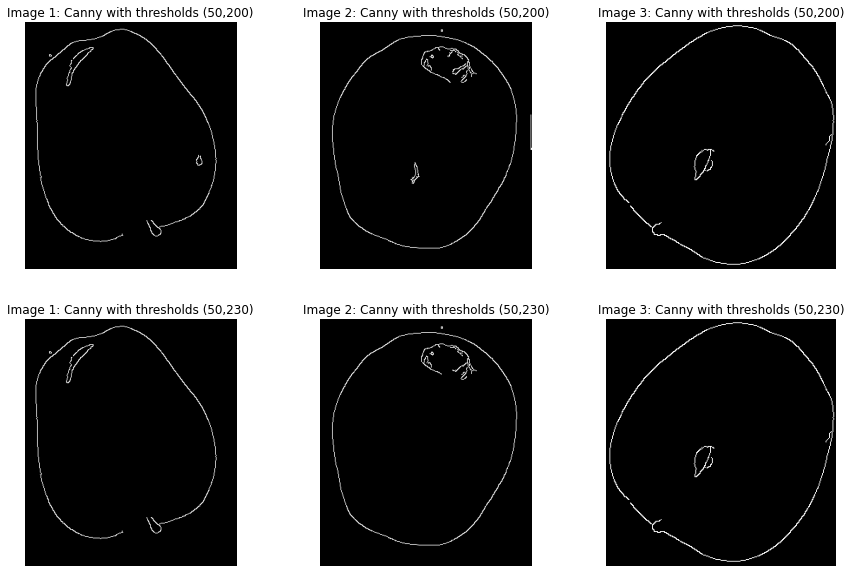

In [9]:
edges_high = []
edges_low = []

plt.figure(figsize=(15,10))
for i, img in enumerate(grayscales):
    edge = cv2.Canny(img, 50, 200)
    edges_low.append(edge)
    plt.subplot(2, N, i+1).axis("off")
    plt.title("Image {0}: Canny with thresholds (50,200)".format(i+1))
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
    edge = cv2.Canny(img, 50, 230)
    edges_high.append(edge)
    plt.subplot(2, N, i+N+1).axis("off")
    plt.title("Image {0}: Canny with thresholds (50,230)".format(i+1))
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
plt.show()

We have decided to keep the couple of thresholds that generates false negative, rather than the one that generates false positive. Such decision is motivated by the nature of the problem itself: every apple has a calyx. Also, thinking about a possible real implementation where this algorithm is used to discard spoiled apples, it would be an unnecessary waste of food to discard false positives.

So, only the results obtained with the couple _(50,230)_ are used for the following operations.

We now use the masks obtained before to eliminate the edges of the apples and only leave imperfections' edges

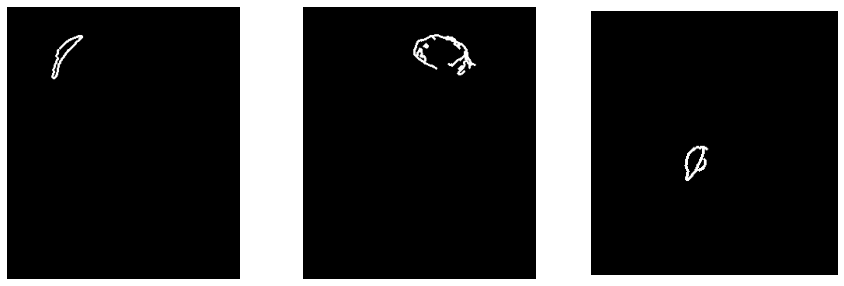

In [10]:
edges = edges_high

plt.figure(figsize=(15,5))
for i, mask in enumerate(ff_masks):
    # Erosion of the binary mask. It will help to proper remove apple edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    eroded_mask = cv2.erode(mask, kernel, iterations = 1)
    # We have setted background to 0, so a pixelwise multiplication is sufficient
    edge = edges[i] * eroded_mask
    # Dilation of the edges. It will help to distinguish better edges when applied on the rgb images later.
    #It would be useless in a real application, it is for demonstration purposes only
    edge = cv2.dilate(edge, kernel, iterations = 1)
    edges[i] = edge
    plt.subplot(1,N,i+1).axis("off")
    plt.imshow(edge, cmap='gray', vmin=0, vmax=255)
plt.show()

### Show results on colored images

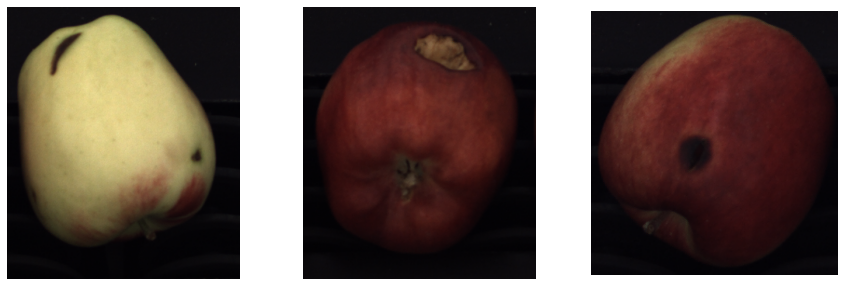

In [11]:
rgb_imgs = []
plt.figure(figsize=(15, 5))
for i, name in enumerate(FILENAMES):
    img_bgr = cv2.imread("img/first task/C1_{0}.png".format(name))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rgb_imgs.append(img_rgb)
    plt.subplot(1,N,i+1).axis("off")
    plt.imshow(img_rgb)
plt.show()

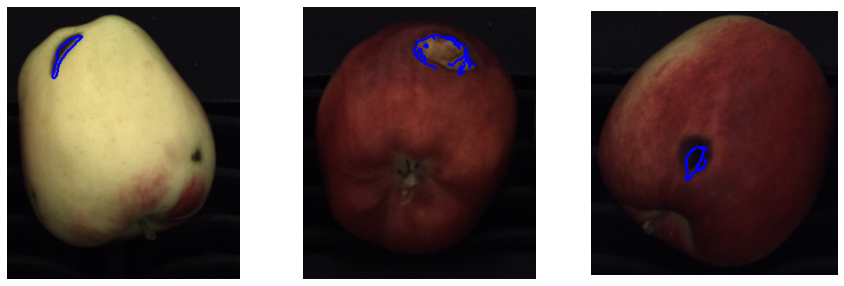

In [12]:
results = []
plt.figure(figsize=(15, 5))
for i, rgb in enumerate(rgb_imgs):
    m, n, _ = rgb.shape
    for j in range(m):
        for k in range(n):
            if edges[i][j,k] != 0:
                rgb[j,k,0] = 0
                rgb[j,k,1] = 0
                rgb[j,k,2] = 255
    results.append(rgb)
    plt.subplot(1,N,i+1).axis("off")
    plt.imshow(rgb)
plt.show()

Imperfection detected are marked in blue

## Task 2: Russet detection
### Preliminary operations and images import

In [13]:
FILENAMES2 = ["000004","000005"]
N2 = len(FILENAMES2)

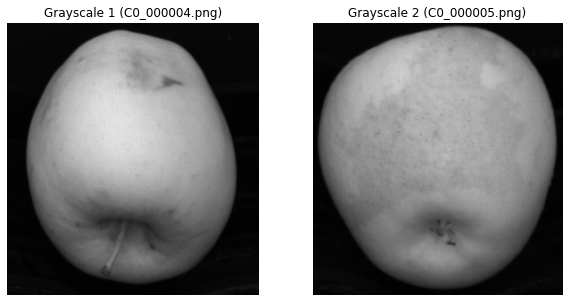

In [14]:
grayscales2 = []
plt.figure(figsize=(10, 5))

for i, name in enumerate(FILENAMES2):
    img = cv2.imread("img/second task/C0_{0}.png".format(name), cv2.IMREAD_GRAYSCALE)
    grayscales2.append(img)
    plt.subplot(1,N2,i+1).axis("off")
    plt.title("Grayscale {0} (C0_{1}.png)".format(i+1, name))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

### Fruit segmentation

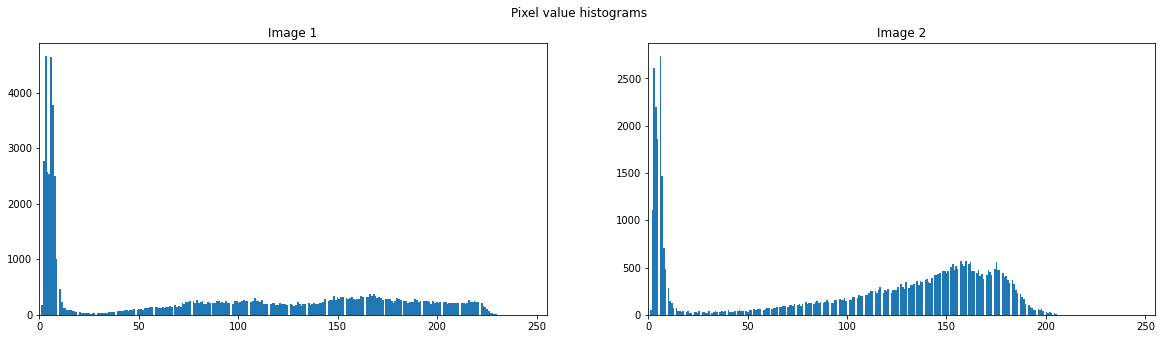

In [15]:
fig = plt.figure(figsize=(20, 5))
for i, img in enumerate(grayscales2):
    # flatten to 1D array
    vals = img.flatten()
    # plot histogram with 255 bins
    plt.subplot(1,N2,i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])
fig.suptitle("Pixel value histograms")
plt.show()

Histograms show that a good threshold should stay between around 20 and 75. We have tried 3 different thresholds: 20, 50 and 75

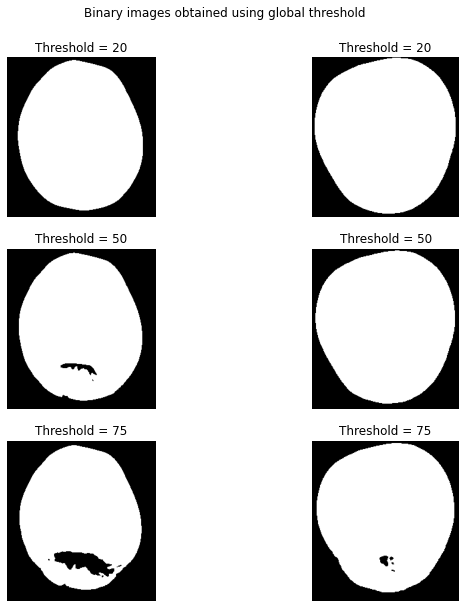

In [16]:
masks2 = []
fig = plt.figure(figsize=(10, 10))

for i, img in enumerate(grayscales2):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret,thresh = cv2.threshold(blur, 20, 1, cv2.THRESH_BINARY)
    ret,thresh1 = cv2.threshold(blur, 50, 1, cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(blur, 75, 1, cv2.THRESH_BINARY)
    masks2.append(thresh2)
    
    a = fig.add_subplot(3,2, i+1)
    a.set_title('Threshold = 20')
    a.axis("off")
    plt.imshow(thresh, 'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,2,i+3)
    a.set_title('Threshold = 50')
    a.axis("off")
    plt.imshow(thresh1 ,'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,2,i+5)
    a.set_title('Threshold = 75')
    a.axis("off")
    plt.imshow(thresh2 , 'gray' ,vmin=0, vmax=1)
fig.suptitle("Binary images obtained using global threshold", y=0.95)
plt.show()


We also tried to use Otsu's algorithm but in the generated mask we can see that part of the foreground 
has the same color of the background. For this reason we decided to utilize global thresholding with threshold 75: while holes are not a problem because we can flood-fill them later, we want to avoid as much as possible background pixels in our masks

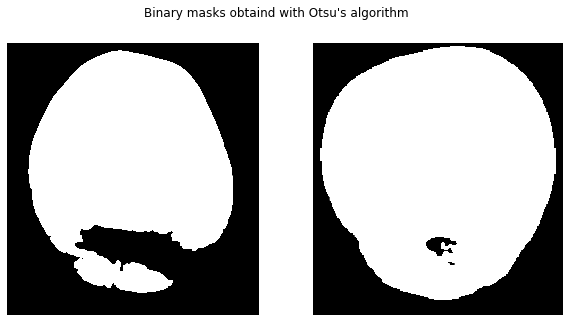

In [17]:
otsu_masks = []

fig = plt.figure(figsize=(10,5))
for i, img in enumerate(grayscales2):
    # (1,1) => no blur
    blur = cv2.GaussianBlur(img,(3,3),0)
    ret, mask = cv2.threshold(blur, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    otsu_masks.append(mask)
    plt.subplot(1,N2,i+1).axis("off")
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
fig.suptitle("Binary masks obtaind with Otsu's algorithm")
plt.show()

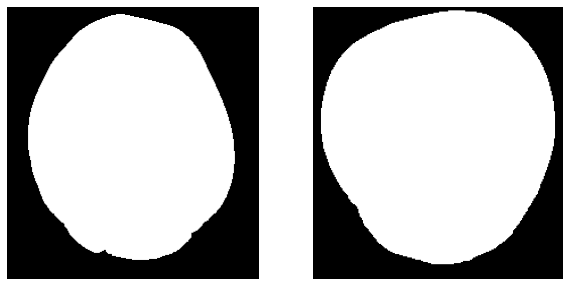

In [18]:
#Flood-fill
ff_masks2 = []
fig = plt.figure(figsize=(10, 5))
for k, mask in enumerate(masks2):
    # Add 1 to each pixel, then set the background to 0. Having it set to 0 will simplify further calculus
    ff_m = mask + 1
    cv2.floodFill(ff_m, None, (0,0), 0)
    m, n = ff_m.shape
    for i in range(m):
        for j in range(n):
            if ff_m[i,j] == 2:
                ff_m[i,j] = 1
    ff_masks2.append(ff_m)
    plt.subplot(1,2,k+1).axis("off")
    plt.imshow(ff_m, cmap='gray', vmin=0, vmax=1)
plt.show()

### Color thresholding
Our first attempt to detect russet areas was to use the most common techniques of color segmentation: Mahalanobis and Euclidean distance thresholding. We have tried both distances for 4 different space colors: RGB, HLS, HSV and LUV. We have also tried different thresholds, different preprocessing steps, and also different ways to obtain the color from which calculates the distances. And while we were able to obtain good results for the single images, using a specific distance for each image, we did not manage to obtain satisfactory global results.
The main problem with color thresholding was the big color differences between the two images: in one image there is a yellow apple with dark brown areas, in the other one we have a green apple with light brown areas. So, if we compute an average color for either the spoiled or the not spoiled regions of one apple, color thresholding will perform good with that apple, but will not be suitable for the other one. This make impossible to achieve a general fully-automatic algorithm.

Since it required long portions of code, we have excluded our attempts from this document, but the most important steps are available in [Failed attempts/Task_2.ipynb](https://github.com/valentinaboriano/Computer-Vision/blob/main/Failed%20attempts/Task_2.ipynb).

Better results have been obtained analyzing single channels.

We start applying the binary masks obtained above to color images and converting them in the 4 color spaces chosen.

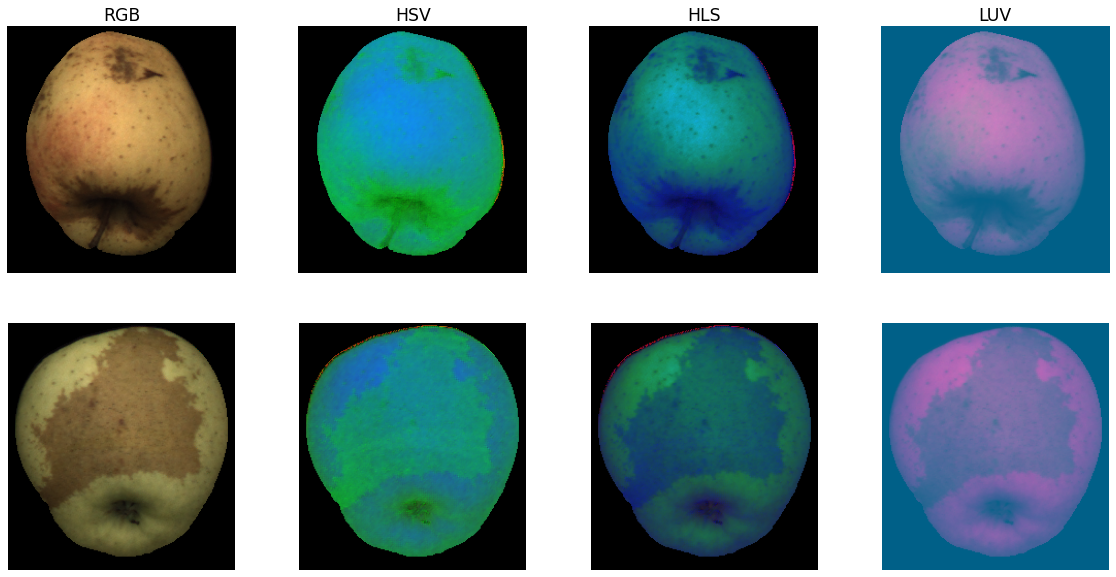

In [19]:
color_spaces = [(cv2.COLOR_BGR2RGB, "RGB"),
                (cv2.COLOR_BGR2HSV, "HSV"),
                (cv2.COLOR_BGR2HLS, "HLS"),
                (cv2.COLOR_BGR2Luv, "LUV")]
n_spaces = len(color_spaces)

colored_images = [[] for i in range(N2)]

pos = 1
plt.figure(figsize=(20, 10))
for i, name in enumerate(FILENAMES2):
    img_bgr = cv2.imread("img/second task/C1_{0}.png".format(name))
    #apply mask
    for j in range(img_bgr.shape[2]):
        img_bgr[:,:,j] *= ff_masks2[i]
    for cs, cs_name in color_spaces:
        converted = cv2.cvtColor(img_bgr, cs)
        colored_images[i].append(converted)
        sub = plt.subplot(N2, n_spaces, pos)
        sub.axis("off")
        if pos <=4:
            sub.set_title(cs_name, size="xx-large")
        pos+= 1
        plt.imshow(converted)
plt.show()

(0,0,0) remains (0,0,0) in every color space, but in LUV, so we need to re-apply the mask to the LUV images:

In [20]:
for i in range(N2):
    for j in range(img_bgr.shape[2]):
        colored_images[i][3][:,:,j] *= ff_masks2[i]

Now we can show channels separately:

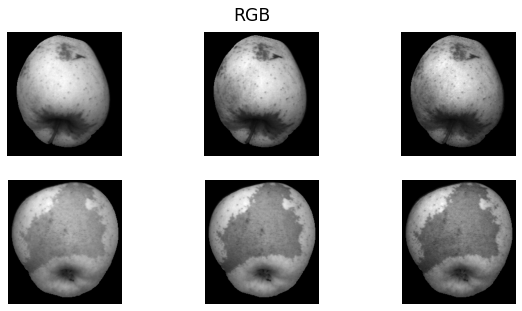

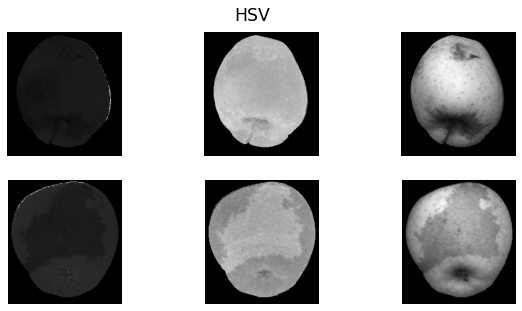

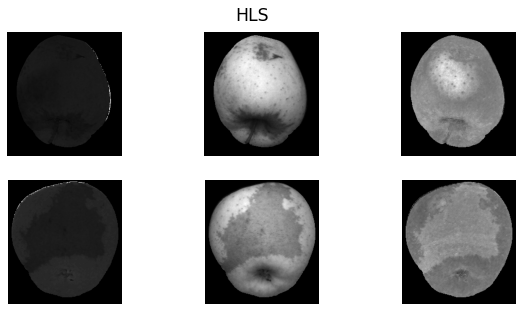

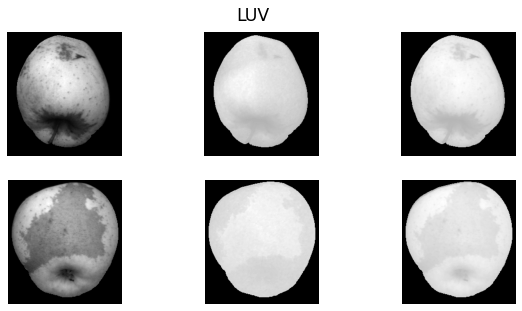

In [21]:
# Plot everything again, but one channel at time
for i in range(n_spaces):
    pos = 1
    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(color_spaces[i][1], fontsize="xx-large", y=0.95)
    for j in range(N2):
        for c in range(3):
            plt.subplot(N2, 3, pos).axis("off")
            pos+= 1
            plt.imshow(colored_images[j][i][:,:,c], cmap='gray')
    plt.show()

In some channels russet regions have quite distinguishable values. In particular:
- G and B from RGB
- V from HSV
- L from HLS
- L and V from LUV

Best results were obtained with channel L from LUV.
Since lighting is not perfectly uniform (peripheral regions of the foreground are darker) because of roundness of apples, we have used an adaptive threshold

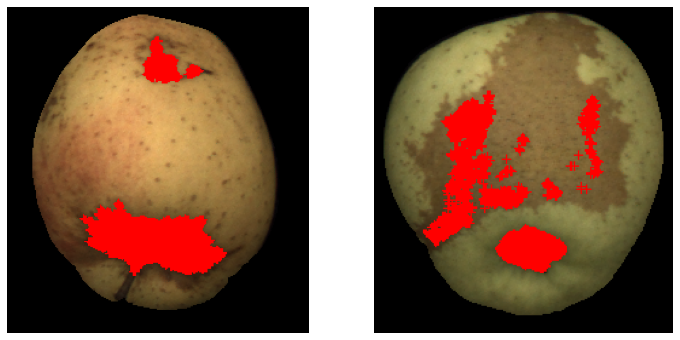

In [22]:
Ls = []
plt.figure(figsize=(12,6))
pos = 1
# For each image
for i in range(N2):
    # Take L channel from LUV
    L = np.copy(colored_images[i][3][:,:,0])
    Ls.append(L)
    # Adaptive thresholding with 99x99 neighbourhood
    th = cv2.adaptiveThreshold(L,1,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,99,2)
    # Opening by a cross structuring element to remove little russet spots that are a regular part of apple's texture
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (7,7))
    opening = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
    # Erosion of the binary mask. It will be used to remove backgrounds point that are still present
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    eroded_mask = cv2.erode(ff_masks2[i],kernel,iterations = 1)
    m,n = opening.shape
    result = np.copy(colored_images[i][0])
    for j in range(m):
        for k in range(n):
            if opening[j,k] == 1 and eroded_mask[j,k] == 1:
                result[j,k,:] = [255,0,0]
    plt.subplot(1,N2,pos).axis("off")
    pos += 1
    plt.imshow(result)
plt.show()

## Task 3: Kiwi Inspection

In [23]:
# Set some constants needed in the code

FILENAMES3 = ["000006","000007","000008","000009","000010"]
N3 = len(FILENAMES3)

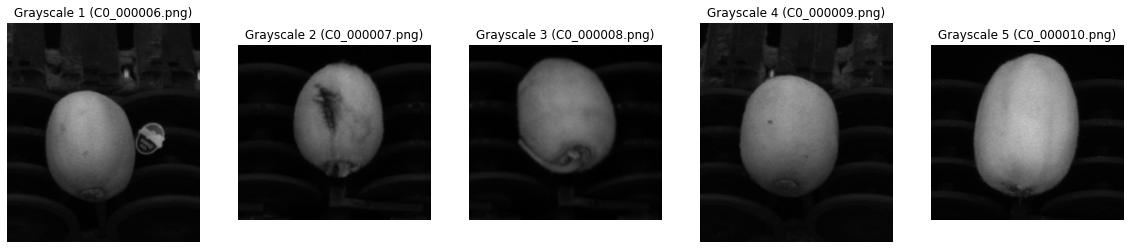

In [24]:
#Import grayscale images
grayscales3 = []
plt.figure(figsize=(20, 5))

for i, name in enumerate(FILENAMES3):
    img = cv2.imread("img/final challenge/C0_{0}.png".format(name), cv2.IMREAD_GRAYSCALE)
    grayscales3.append(img)
    plt.subplot(1,N3,i+1).axis("off")
    plt.title("Grayscale {0} (C0_{1}.png)".format(i+1, name))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

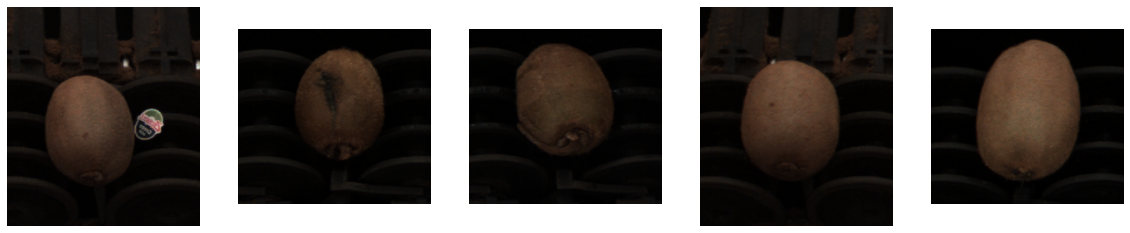

In [25]:
#Import rgb images
rgb3 = []
plt.figure(figsize=(20, 5))
for i, name in enumerate(FILENAMES3):
    img_bgr = cv2.imread("img/final challenge/C1_{0}.png".format(name))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rgb3.append(img_rgb)
    plt.subplot(1,N3,i+1).axis("off")
    plt.imshow(img_rgb)
plt.show()

## Fruit Segmentation
At first, we want to create a binary mask for each image. 

We decided to test both: global thresholding and Otsu's algorithm.


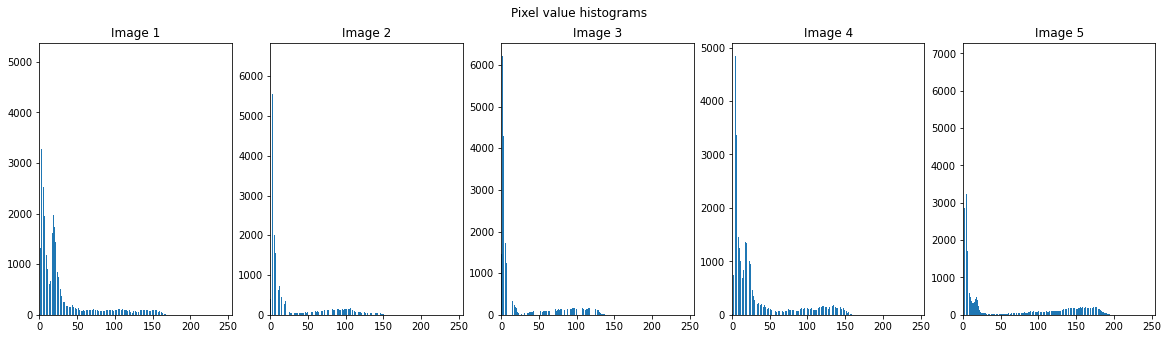

In [26]:
fig = plt.figure(figsize=(20, 5))
for i, img in enumerate(grayscales3):
    # flatten to 1D array
    vals_3 = img.flatten()
    # plot histogram with 255 bins
    plt.subplot(1,N3,i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals_3, 255)
    plt.xlim([0,255])
fig.suptitle("Pixel value histograms")
plt.show()

### Global Thresholding
We have tried different thresholds, we can see that:

When the threshold is equal to 35, the background still has parts of the conveyor, the sticker is still big (in the first image).
When the threshold is equal to 50, the background still has parts of the conveyor, the sticker is still big, and the defect is bigger.
When the threshold is equal to 70, the background has fewer parts of the conveyor, the sticker is smaller and the defect is bigger.

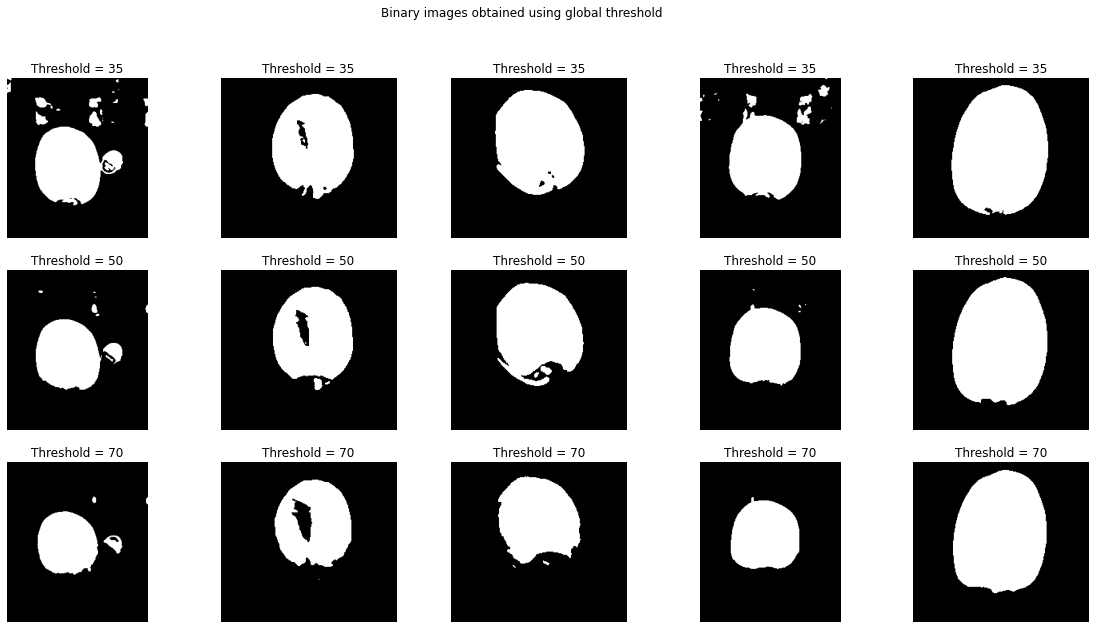

In [27]:
masks3 = []
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(grayscales3):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret,thresh = cv2.threshold(blur,  35, 1, cv2.THRESH_BINARY)
    ret,thresh1 = cv2.threshold(blur, 50, 1, cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(blur, 70, 1, cv2.THRESH_BINARY)
    masks3.append(thresh2)
    a = fig.add_subplot(3,5, i+1)
    a.axis("off")
    a.set_title('Threshold = 35')
    plt.imshow(thresh, 'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,5,i+6)
    a.axis("off")
    a.set_title('Threshold = 50')
    plt.imshow(thresh1 ,'gray' ,vmin=0, vmax=1)
    a = fig.add_subplot(3,5,i+11)
    a.axis("off")
    a.set_title('Threshold = 70')
    plt.imshow(thresh2 , 'gray' ,vmin=0, vmax=1)
fig.suptitle("Binary images obtained using global threshold")
plt.show()

### Otsu's algorithm
We have decided to utilize also Otsu's algorithm but in the generated mask we can see that the sticker is still too big. Therefore, we preferred the results obtained with global thresholding with threshold 70. In fact, even if there are holes in the background of images 1 and 3 and the sticker is still visible, we can be easily correct theese errors with an opening.

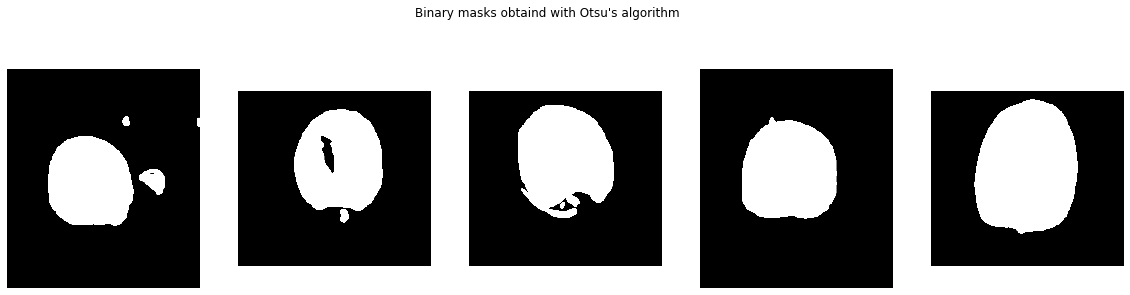

In [28]:
otsu_masks_3 = []

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(grayscales3):
    blur3 = cv2.GaussianBlur(img,(9,9),0)
    ret3, mask_3 = cv2.threshold(blur3, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    otsu_masks_3.append(mask_3)
    plt.subplot(1,N3,i+1).axis("off")
    plt.imshow(mask_3, cmap='gray', vmin=0, vmax=1)
fig.suptitle("Binary masks obtaind with Otsu's algorithm")
plt.show()

## Opening and Dilation
Our first attempt is to correct the white holes in the background, to do this we use the opening morphological operation. 
An opening consists in erosion followed by dilation. It's very useful to reduce noise.

However, results weren't satisfying enough, because after the application of the opening the defect in the second image merges with the background. For this reason we decided to follow the opening with a dilation, to increase a bit the foreground. Results obtained are shown below.

If we have used other masks (with global threshold 35 or 50) the sticker would have belonged to the foreground or the defect would have belonged to the background.

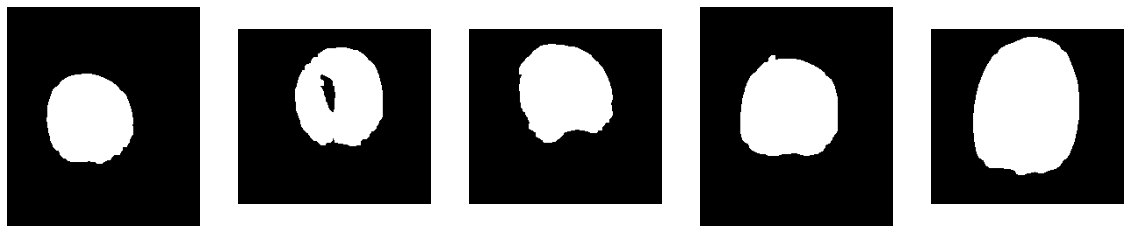

In [29]:
mask_op = []
plt.figure(figsize=(20,10))
kernel1 = np.ones((5,5), np.uint8) 
for i, img in enumerate(masks3):  
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (17,18))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    dilation = cv2.dilate(opening, kernel1)
    mask_op.append(dilation)
    plt.subplot(1, N3, i+1).axis("off")
    plt.imshow(dilation, cmap= "gray")
plt.show()

We have defined a function that recognize if a kiwi has a defect or not, using openCV's floodFill function. Then we have shown the rgb image with the defect (marked in red) and the title that describe if is a "good kiwi" or a "bad kiwi"

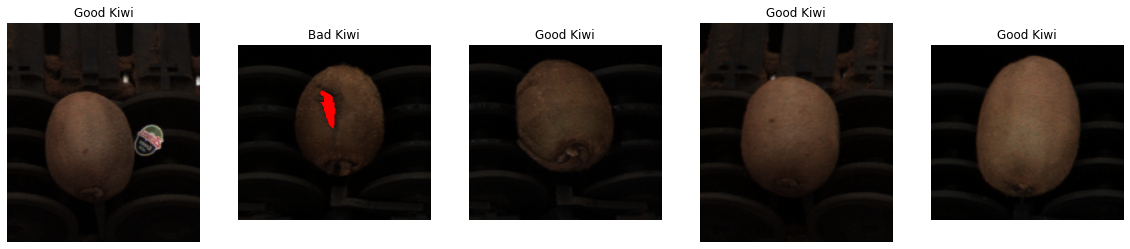

In [30]:
plt.figure(figsize=(20,15))
kiwi_img = rgb3.copy()
for i, img in enumerate(mask_op):
    boolean = True
    cv2.floodFill(img, None, (0,0),1)
    m, n, _ = kiwi_img[i].shape
    is_good = np.all(img)
    if not is_good:
        x, y = img.shape
        for j in range(x):
            for k in range(y):
                if img[j, k] == 0:
                    kiwi_img[i][j, k, :] = [255, 0, 0]
    string = "Good Kiwi" if is_good else "Bad Kiwi"        
    plt.subplot(1, N3, i+1).axis("off")
    plt.title(string)
    plt.imshow(kiwi_img[i], cmap = 'gray')
plt.show()